In [65]:
from ultralytics.data.utils import polygon2mask, visualize_image_annotations
from ultralytics.data.annotator import auto_annotate
import cv2
import numpy as np
from pathlib import Path
import random

In [16]:
INPUT_PATH=Path("./segtest")
SEG_PATH=Path("./seg")
LABEL_PATH=Path("./project_yasuke/labels")
BG_PATH=Path("./background")
OUTPUT_PATH=Path("./output")
NUM_AUG=12
OUT_FILENAME="AUG_{0}_{1}"

In [ ]:
auto_annotate(data=INPUT_PATH, det_model="yolo11x.pt", sam_model="sam2.1_l.pt", classes=[41], device="cuda:0", output_dir=SEG_PATH)

In [42]:
def read_seg(ipath, imgsz):
    lmask=[]
    with open(SEG_PATH/(ipath.with_suffix(".txt").name), "r") as f:
        for line in f:
            cont=line.split()
            if cont:
                ncls, seg = cont[0], cont[1:]
                if (not ncls=="41"):
                    continue
                seg = np.array(seg).astype(float).reshape((-1,2))
                lmask.append(
                    polygon2mask(
                        imgsz,
                        [seg*imgsz[::-1]],
                        color=1,
                        downsample_ratio=1,
                    )
                )
    return sorted(lmask, key=lambda m: np.sum(m))[-1]

In [44]:
def blend_img(img, bgimg, mask):
    imgsz=img.shape[:2]
    bgsz=bgimg.shape[:2]
    mask=cv2.GaussianBlur(mask, (0,0), sigmaX=4, sigmaY=4)
    bg_reshape=(cv2.resize(bgimg,(np.array(bgsz)[::-1]*np.max(np.array(imgsz)/np.array(bgsz))).astype(int))[:imgsz[0],:imgsz[1]])
    return (img.T*mask.T+bg_reshape.T*(1-mask.T)).T

In [50]:
def read_label(ipath):
    bbox=(0,None)
    with open(LABEL_PATH/(ipath.with_suffix(".txt").name), "r") as f:
        for line in f:
            cont = line.split()
            if cont:
                ncls, ibbox=cont[0], cont[1:]
                if ncls=="1":
                    assert len(ibbox)==4
                    bbox=max(bbox, (np.prod(np.array(ibbox[-2:]).astype(float)), ibbox))
    return bbox[-1]

In [46]:
imgs=list(INPUT_PATH.glob("*.jpg"))
bg_imgs=[(p, cv2.imread(p)) for p in BG_PATH.glob("*.jpg")]

In [62]:
Path.mkdir(OUTPUT_PATH, parents=True, exist_ok=True)

for pimg in imgs:
    for bg_path, bg_img in random.sample(bg_imgs, NUM_AUG):
        img=cv2.imread(pimg)
        mask=read_seg(pimg,img.shape[:2])
        outpath=OUTPUT_PATH/pimg.with_stem(OUT_FILENAME.format(pimg.stem, bg_path.stem)).name
        print(f"Aug {pimg} with {bg_path}, output: {outpath}")
        cv2.imwrite(outpath, blend_img(img,bg_img,mask))
        with open(outpath.with_suffix(".txt"),"w") as f:
            f.write(f"1 {" ".join(read_label(pimg))}")
    

Aug segtest/VID_20250210_170855_00027.jpg with background/b1.jpg, output: output/AUG_VID_20250210_170855_00027_b1.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b5.jpg, output: output/AUG_VID_20250210_170855_00027_b5.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b11.jpg, output: output/AUG_VID_20250210_170855_00027_b11.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b6.jpg, output: output/AUG_VID_20250210_170855_00027_b6.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b9.jpg, output: output/AUG_VID_20250210_170855_00027_b9.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b7.jpg, output: output/AUG_VID_20250210_170855_00027_b7.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b10.jpg, output: output/AUG_VID_20250210_170855_00027_b10.jpg
Aug segtest/VID_20250210_170855_00027.jpg with background/b12.jpg, output: output/AUG_VID_20250210_170855_00027_b12.jpg
Aug segtest/VID_20250210_170855_00027.jpg with bac

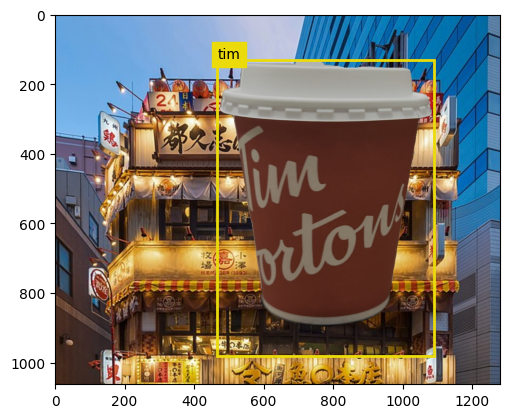

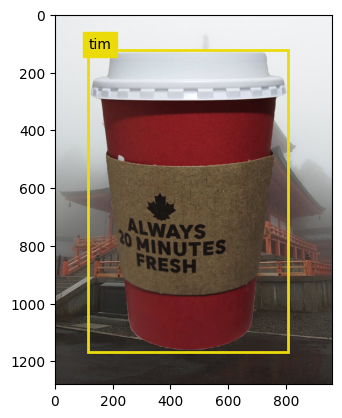

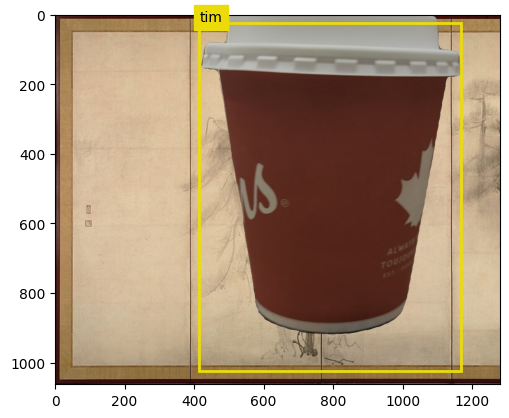

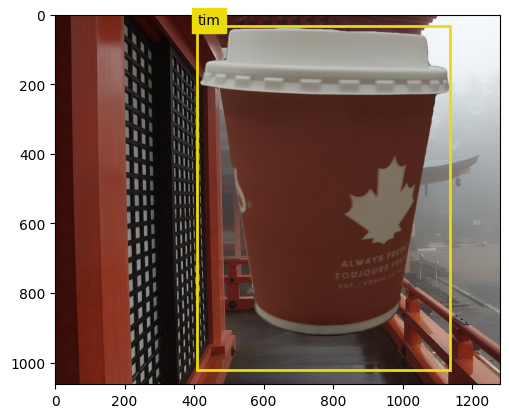

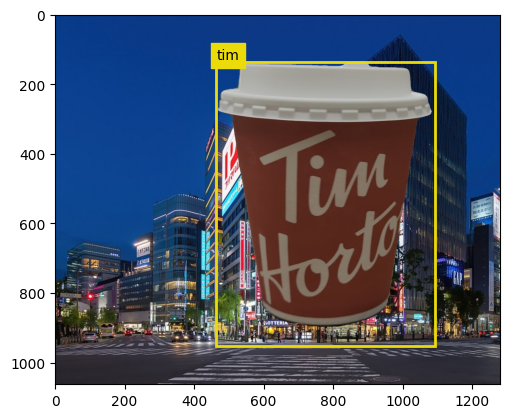

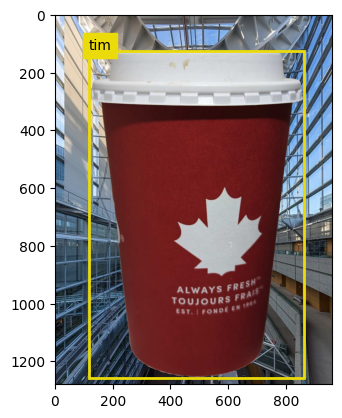

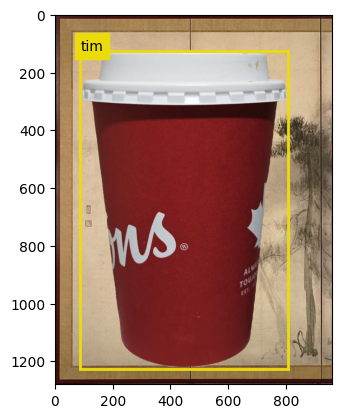

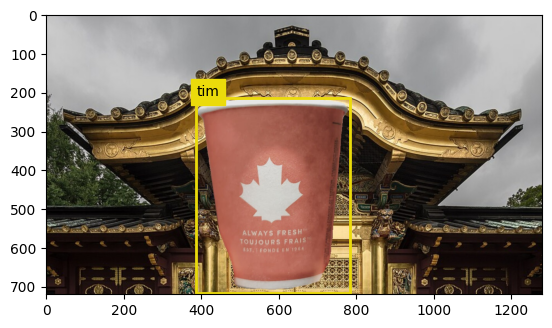

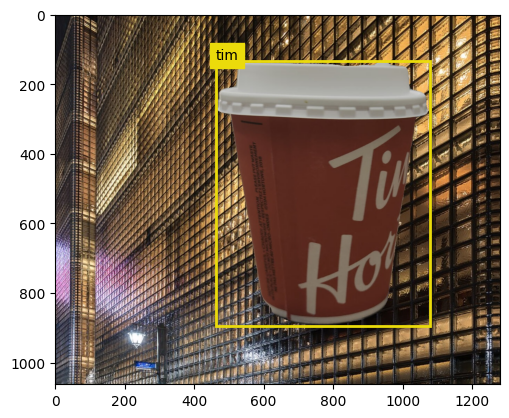

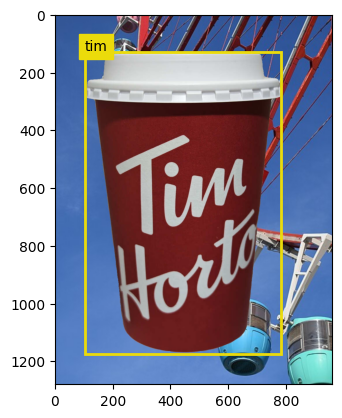

In [73]:
INSPECT_NUM=10
for p in random.sample(list(OUTPUT_PATH.glob("*.jpg")), INSPECT_NUM):
    visualize_image_annotations(p, p.with_suffix(".txt"), {0:"cup", 1:"tim"})